## PART 1:

In this part of the mini-project, we use NinaPro Dataset 1 (https://ninapro.hevs.ch/instructions/DB1.html) to classify and predict the movement classes associated to the different EMG signals for a single subject. Participants are tasked  to replicate the movement shown on the screen. Surface EMG signals are recorded while the  participants perform the tasks.  

Article: “Electromyography Data for Non-Invasive Naturally-Controlled Robotic Hand Prostheses” (Scientific Data, 2014)


Method:Here we are concerned with Surface electromyography (sEMG). The sEMG data are acquired using 10 Otto Bock MyoBock 13E200 electrodes, while kinematic data are acquired using a Cyberglove 2 data glove. The sampling rate on sEMG is 100 Hz.

The data comes from S2: Intact (this is, non amputee)	Right Handed	Male	27	years old

In [59]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
from scipy.integrate import simpson  
import pandas as pd

### 1. Preprocess and Visualize

In [60]:
#data = loadmat("/Users/pamelavandenenden/Desktop/nssp_project2/s2/S2_A1_E1.mat")
data = loadmat("s2[1]/S2_A1_E1.mat")

In [61]:
print(f"What kind of data structure are we working with? {type(data)}")
print(f"What are the keys of the data structure? {[key for key in data.keys()]}") 

What kind of data structure are we working with? <class 'dict'>
What are the keys of the data structure? ['__header__', '__version__', '__globals__', 'subject', 'exercise', 'stimulus', 'emg', 'glove', 'restimulus', 'repetition', 'rerepetition']


#### 1a. Review Data

In [62]:
#Restimulus and rerepetition are the stimulus and repetition that have been processed for better correspondance to real movement

#Stimulus is the type of movement that is being performed
stimulus = data["restimulus"] 
#Repetition is the number of times the movement has been repeated
repetition = data["rerepetition"] 


emg_rectified = data["emg"].copy()
print(f'What are the shape of the data that we are working with? \nEMG: {emg_rectified.shape}, \nStimulus {stimulus.shape}, \nRepetition {repetition.shape}')

What are the shape of the data that we are working with? 
EMG: (100686, 10), 
Stimulus (100686, 1), 
Repetition (100686, 1)


In [63]:
# We want to know how many movements. repetitions and number of channels in this data set:


n_stimuli = len(np.unique(stimulus)) - 1  # -1 because 0 is the resting condition

n_repetitions = len(np.unique(repetition)) - 1  # -1 because 0 is not a repetition


n_channels = emg_rectified.shape[1]

print(f'How many types of movement are there? {n_stimuli}') 
print(f'How many repetitions are there? {n_repetitions}')
print(f'How many channels are there? {n_channels}')

How many types of movement are there? 12
How many repetitions are there? 10
How many channels are there? 10


In [64]:
#Duration of trials (i.e. number of samples within a repetition of a stimulus):

number_of_samples_per_trial = np.zeros((n_stimuli, n_repetitions))

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        
        idx = np.logical_and(stimulus == stimuli_idx+1, repetition == repetition_idx+1)
        number_of_samples_per_trial[stimuli_idx, repetition_idx] = np.sum(idx.astype(int))

number_of_samples_per_trial

array([[307., 390., 262., 226., 418., 204., 196., 270., 306., 489.],
       [334., 323., 344., 309., 333., 376., 362., 307., 348., 339.],
       [465., 352., 450., 460., 436., 389., 323., 388., 383., 316.],
       [310., 402., 357., 396., 255., 333., 263., 369., 438., 471.],
       [516., 382., 425., 379., 463., 411., 387., 343., 286., 377.],
       [337., 319., 337., 368., 338., 336., 268., 354., 319., 313.],
       [428., 392., 341., 393., 421., 445., 342., 328., 329., 358.],
       [289., 372., 406., 397., 498., 336., 415., 328., 472., 405.],
       [384., 424., 371., 316., 280., 314., 342., 284., 307., 421.],
       [311., 296., 299., 296., 301., 246., 213., 317., 493., 221.],
       [352., 403., 338., 416., 330., 355., 313., 322., 329., 219.],
       [270., 330., 300., 387., 295., 204., 363., 267., 281., 329.]])

#### 1b. Preprocess

Question 1: Visualize and preprocess the data for subject 2 (use only the first exercise set:  S2_A1_E1 with 12 actions). Does the data look reasonable? Did you need to remove  any trials?  

In [65]:
# Calculate sampling frequency:

# We calculate the duration of the first trial under two EMG sampling rate assumptions from the data website: Both 100 Hz and 2000 Hz are reported.

samples_in_trial = number_of_samples_per_trial[0, 0] # e.g., ~400 samples
duration_100hz = samples_in_trial / 100.0
duration_2000hz = samples_in_trial / 2000.0

print(f"Trial Samples: {int(samples_in_trial)}")
print(f"Calculated Duration at 100 Hz:  {duration_100hz:.2f} s")
print(f"Calculated Duration at 2000 Hz: {duration_2000hz:.2f} s") 

# Logic: A standard isometric contraction trial typically lasts 3-5 seconds.
if duration_100hz > 1.0:
    fs = 100
    print(f"Detected Sampling Frequency: {fs} Hz")
else:
    fs = 2000
    print(f"Detected Sampling Frequency: {fs} Hz")

Trial Samples: 307
Calculated Duration at 100 Hz:  3.07 s
Calculated Duration at 2000 Hz: 0.15 s
Detected Sampling Frequency: 100 Hz


Conclusion : 100 Hz, the standard Ninapro DB1 protocol (Otto Bock sensors)


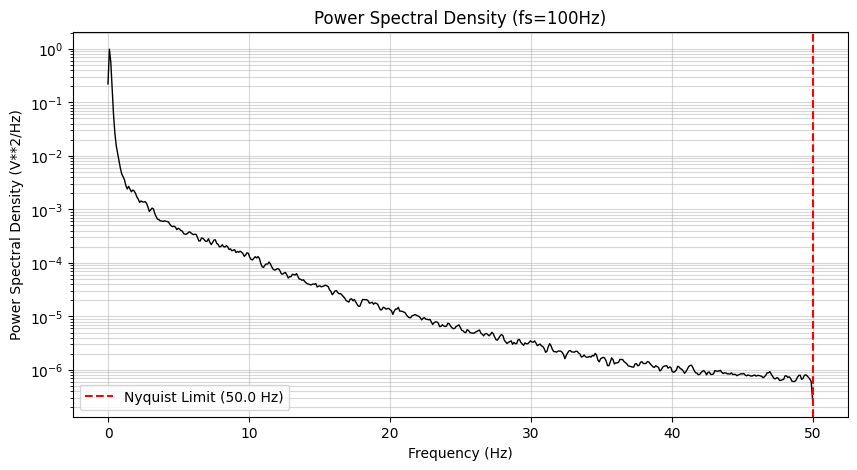

In [66]:
# Spectral Density Filter: PSD using welch method to inspect frequency content:

#Inspect channel 1:
freqs, psd = welch(emg_rectified[:, 0], fs=fs, nperseg=1024)

plt.figure(figsize=(10, 5))
plt.semilogy(freqs, psd, color='black', linewidth=1)
plt.title(f"Power Spectral Density (fs={fs}Hz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (V**2/Hz)")
plt.grid(True, which='both', alpha=0.5)

# Mark the Nyquist Frequency (fs/2)
nyquist = fs / 2
plt.axvline(nyquist, color='red', linestyle='--', label=f'Nyquist Limit ({nyquist} Hz)')
plt.legend()
plt.show()

Conclusion: The maximum observable frequency (Nyquist frequency) is half the sampling rate. The frequency content on the x-axis terminates exactly at 50 Hz.

Do we need bandpass filtering? No, our data is already below 500Hz. 
Do we need notch filtering? No, there is no spike at 50Hz in the PSD plot. 

##### Segment and Smooth the data

Segmentation of continous stream into sample, sliding window to calculate the envelope of the raw data. That is, smoothing.

First, we rectify. Rectification: The raw EMG signal swings positive and negative. If we averaged them, they would cancel out to zero. So, we flip all negative values to be positive. Now the signal represents pure "magnitude" or energy


Second we smooth. Smoothing: The rectified signal is still too "spiky" (stochastic). Muscles don't turn on and off 100 times a second; they ramp up and down slowly. We apply the Moving Average. 

In [67]:
# Define the smoothing filter:

# Moving average window (as per Lab instructions)
mov_mean_length = 25
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length # Average of N (25) neighboring samples

# Initialize the empty data structures
emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]
emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]


# Rectification and Smoothing Loop:
for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        # Create the mask to find where this specific trial is in the data
        idx = np.logical_and(stimulus == stimuli_idx + 1, repetition == repetition_idx + 1).flatten()
        
        # --- DEFINE current_window ---
        # Slice the raw data using the mask
        current_window = emg_rectified[idx, :] 
        
        # --- DEFINE envelope ---
        # Apply rectification (abs) and smoothing (convolve) to every channel
        envelope = np.array([np.convolve(np.abs(col), mov_mean_weights, mode='same') for col in current_window.T]).T #np.abs(col): Rectification. It turns all negative muscle values positive.

        # Store the results in the data structures
        emg_windows[stimuli_idx][repetition_idx] = current_window
        emg_envelopes[stimuli_idx][repetition_idx] = envelope



In [68]:
# Now, we want to check our raw and enveloped data visually using interactive plots:
# Important: The y axis limits should be the same across all channels for better comparison. 
'''

!!!!!!!!!!!!!   TAKES FOREVERRRRRR     !!!!!!!!!!!!!!!


from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt
import numpy as np

def view_trial(stimulus=1, repetition=1):
    # Convert to Python Index
    s_idx = stimulus - 1
    r_idx = repetition - 1

    current_raw = emg_windows[s_idx][r_idx]
    current_env = emg_envelopes[s_idx][r_idx]

    # We set a minimum floor (e.g., 0.1) to prevent errors on empty channels
    raw_ylim = max(np.max(current_raw) * 1.1, 0.05)
    env_ylim = max(np.max(current_env) * 1.1, 0.05)

    # Row 1: Raw | Row 2: Envelope
    fig, axes = plt.subplots(2, 10, figsize=(18, 6), constrained_layout=True)
    
    # 10 EMG channels
    number_of_emg_channels = current_raw.shape[1]

    for ch in range(number_of_emg_channels): 
        # RAW
        ax_raw = axes[0, ch]
        ax_raw.plot(current_raw[:, ch], color='#4c72b0')
        ax_raw.set_title(f"Ch {ch+1}")
        ax_raw.set_ylim(0, raw_ylim) # Uniform Scale
        ax_raw.grid(True, alpha=0.3)
        if ch == 0: ax_raw.set_ylabel("RAW")
        
        # ENVELOPE
        ax_env = axes[1, ch]
        ax_env.plot(current_env[:, ch], color='#dd8452', linewidth=2)
        ax_env.set_title(f"Ch {ch+1}")
        ax_env.set_ylim(0, env_ylim) # Uniform Scale
        ax_env.grid(True, alpha=0.3)
        if ch == 0: ax_env.set_ylabel("ENVELOPE")

    plt.suptitle(f"Stimulus {stimulus} | Repetition {repetition}", fontsize=16)
    plt.show()

# Create the sliders
print("Use the sliders to loop through your data:")
interact(view_trial, 
         stimulus=IntSlider(min=1, max=n_stimuli, step=1, value=1), 
         repetition=IntSlider(min=1, max=n_repetitions, step=1, value=1));

'''

'\n\n!!!!!!!!!!!!!   TAKES FOREVERRRRRR     !!!!!!!!!!!!!!!\n\n\nfrom ipywidgets import interact, IntSlider\nimport matplotlib.pyplot as plt\nimport numpy as np\n\ndef view_trial(stimulus=1, repetition=1):\n    # Convert to Python Index\n    s_idx = stimulus - 1\n    r_idx = repetition - 1\n\n    current_raw = emg_windows[s_idx][r_idx]\n    current_env = emg_envelopes[s_idx][r_idx]\n\n    # We set a minimum floor (e.g., 0.1) to prevent errors on empty channels\n    raw_ylim = max(np.max(current_raw) * 1.1, 0.05)\n    env_ylim = max(np.max(current_env) * 1.1, 0.05)\n\n    # Row 1: Raw | Row 2: Envelope\n    fig, axes = plt.subplots(2, 10, figsize=(18, 6), constrained_layout=True)\n    \n    # 10 EMG channels\n    number_of_emg_channels = current_raw.shape[1]\n\n    for ch in range(number_of_emg_channels): \n        # RAW\n        ax_raw = axes[0, ch]\n        ax_raw.plot(current_raw[:, ch], color=\'#4c72b0\')\n        ax_raw.set_title(f"Ch {ch+1}")\n        ax_raw.set_ylim(0, raw_ylim) 

To review: Channels were the values seem a bit too high. I have not deleted them since in the previous lab we were not taught how to do that. 

Stimulus 7, Repetition 1, Channel 9 

Stimulus 7, Repetition 4, Channel 9 

Stimulus 7, Repetition 7, Channel 9

Stimulus 9, Repetition 8: Channel 9

Stimulus 11, Repetition 5, Channel 1

### NOTE
The paper does some pre-processing that is different from what we did before:

They use butterworth filerting. 

In [69]:
'''
from scipy.signal import butter, lfilter

fs = 100
window_size = 20   # 200 ms
step_size = 10     # 100 ms (50% overlap)
test_reps = [2, 5, 7] 

def apply_ninapro_filter(data):
    b, a = butter(N=1, Wn=1, btype='low', fs=fs)
    return lfilter(b, a, data, axis=0)

emg_processed = apply_ninapro_filter(emg_rectified)
'''

"\nfrom scipy.signal import butter, lfilter\n\nfs = 100\nwindow_size = 20   # 200 ms\nstep_size = 10     # 100 ms (50% overlap)\ntest_reps = [2, 5, 7] \n\ndef apply_ninapro_filter(data):\n    b, a = butter(N=1, Wn=1, btype='low', fs=fs)\n    return lfilter(b, a, data, axis=0)\n\nemg_processed = apply_ninapro_filter(emg_rectified)\n"

### 2. Feature Selection

Question 3: Extract features from the trials (at least 5 different ones), explain briefly why you picked these features. Visualize the typical values of  the features across the different trials. What do you see? Are the values similar  between repetitions and between channels? Explain the possible reasons for  similarity/discrepancies.  

I looked at this paper: https://www.nature.com/articles/sdata201453

These are the features they extracted, plus Discrete Wavelet Transform. But I could not make this function work in my computer. So, Gemini recomends using PSD. 

1. Root Mean Square (RMS)

    Definition: The square root of the arithmetic mean of the squares of the values.
    Scientific Significance: RMS represents the electrical power of the signal. In electromyography, it models the amplitude of the Motor Unit Action Potentials (MUAPs). Under non-fatiguing conditions, RMS is linearly (or quasi-linearly) proportional to the isometric force generated by the muscle.

2. Hudgins’ Time Domain (TD) Features: Proposed by Hudgins et al. (1993), this set characterizes the signal pattern without requiring a transformation to the frequency domain, maintaining low computational complexity.

- Mean Absolute Value (MAV):
    Definition: The average of the absolute amplitude values in the window.
    Significance: A linear estimator of muscle contraction intensity. It is the most common metric used to detect the onset of movement vs. the resting state.

- Waveform Length (WL):
    Definition: The cumulative summation of the absolute difference between consecutive sample points.
    Significance: WL quantifies signal complexity. It implicitly captures both the amplitude and the frequency of the signal (since higher frequency signals travel a longer "distance" over the same time period).

- Zero Crossings (ZC):
    Definition: The number of times the signal amplitude crosses the zero (or mean) threshold.
    Significance: A time-domain estimate of frequency. It correlates with muscle fatigue (spectral compression causes ZC to decrease) and the recruitment of different motor unit types.

- Slope Sign Changes (SSC):
    Definition: The number of times the slope of the signal changes from positive to negative (or vice versa).
    Significance: Captures the frequency of signal turns (local maxima/minima). It provides spectral information similar to ZC but is more robust against low-voltage noise fluctuations.

3. Histogram (HIST)
    Definition: A discretization of the signal amplitude into specific bins based on a 3sigma (standard deviation) threshold.
    Scientific Significance: This estimates the Probability Density Function (PDF) of the signal. While TD features (like MAV) capture the magnitude, HIST captures the statistical distribution. This helps the classifier distinguish between movements that require similar force (similar MAV) but have different firing patterns.

4. Power Spectral Density (PSD)
    Definition: Derived via the Fourier Transform (using periodogram), this decomposes the signal into its constituent frequencies.
    Scientific Significance: This provides Frequency Domain information.

    Total Power: The integral of the PSD.
    Peak Frequency: The frequency component containing the maximum energy. This helps distinguish between different muscle groups, as frequency content varies based on fiber composition (fast-twitch vs. slow-twitch) and electrode placement.

In [70]:
#defining features

#1. Root mean square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))

#2. Mean absolute value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)

#3. Waveform length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)

#4. Zero Crossings
zc = lambda x, thr=0.0: np.sum((x[:-1] * x[1:] < 0) & (np.abs(x[1:] - x[:-1]) >= thr), axis=0)

#5. Slope sign changes (SSC)
ssc = lambda x, thr=0.0: np.sum(
    (np.diff(x, axis=0)[:-1] * np.diff(x, axis=0)[1:] < 0) &
    (np.abs(np.diff(x, axis=0)[:-1]) >= thr) &
    (np.abs(np.diff(x, axis=0)[1:]) >= thr),
    axis=0)

#6. (Power Spectral Density (PSD)
def PSD(x, fs=100, nperseg=None):                        ######### FEED SAMPLING FREQUENCY, FMIN, FMAX HERE
    x = np.atleast_2d(x)
    if x.shape[0] < x.shape[1]:  
        x = x.T
    freqs, psd_vals = welch(x, fs=fs, nperseg=nperseg, axis=0)
    return freqs, psd_vals
psd = lambda x: PSD(x)[1]

#7. Power (time domain)
p_simple = lambda x: np.mean(x**2, axis=0)

#8. Band Power
def bandpower(x, fs=100, fmin=1, fmax=500, nperseg=None):      ######### FEED SAMPLING FREQUENCY, FMIN, FMAX HERE
    x = np.atleast_2d(x)
    if x.shape[0] < x.shape[1]: 
        x = x.T
    freqs, psd_vals = welch(x, fs=fs, nperseg=nperseg, axis=0)
    idx = (freqs >= fmin) & (freqs <= fmax)
    bp = simpson(psd_vals[idx, :], freqs[idx], axis=0) 
    return bp
bp = lambda x: bandpower(x)
#9. Standard Deviation (STD)
std = lambda x: np.std(x, axis=0, ddof=0)
#10. Maximum absolute Value (MaxAV)
maxav = lambda x: np.max(np.abs(x), axis=0)


In [71]:
#function to build dataset

def build_dataset_from_ninapro(emg, stimulus, repetition, features=None):
    # Calculate the number of unique stimuli and repetitions, subtracting 1 to exclude the resting condition
    n_stimuli = np.unique(stimulus).size - 1
    n_repetitions = np.unique(repetition).size - 1
    # Total number of samples is the product of stimuli and repetitions
    n_samples = n_stimuli * n_repetitions
    
    # Number of channels in the EMG data
    n_channels = emg.shape[1]
    # Calculate the total number of features by summing the number of channels for each feature
    n_features = sum(n_channels for feature in features)
    
    # Initialize the dataset and labels arrays with zeros
    dataset = np.zeros((n_samples, n_features))
    labels = np.zeros(n_samples)
    current_sample_index = 0
    
    # Loop over each stimulus and repetition to extract features
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            # Assign the label for the current sample
            labels[current_sample_index] = i + 1
            # Calculate the current sample index based on stimulus and repetition
            current_sample_index = i * n_repetitions + j
            current_feature_index = 0
            # Select the time steps corresponding to the current stimulus and repetition
            selected_tsteps = np.logical_and(stimulus == i + 1, repetition == j + 1).squeeze()
            
            # Loop over each feature function provided
            for feature in features:
                # Determine the indices in the dataset where the current feature will be stored
                selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
                # Apply the feature function to the selected EMG data and store the result
                dataset[current_sample_index, selected_features] = feature(emg[selected_tsteps, :])
                # Update the feature index for the next feature
                current_feature_index += n_channels

            # Move to the next sample
            current_sample_index += 1
            
    # Return the constructed dataset and corresponding labels
    return dataset, labels

In [72]:
dataset, labels = build_dataset_from_ninapro(
    emg=emg_rectified, ##########????
    stimulus=stimulus,
    repetition=repetition,
    features=[rms, mav, wl, zc, ssc, p_simple, std, maxav]) #add psd, bp later, output format causing issues

print(f"dataset dimension: {dataset.shape}")
print(f"labels dimension: {labels.shape}")

dataset dimension: (120, 80)
labels dimension: (120,)


### 3. Split Data:

Question 2: Split the data into training, validation, and testing sets for the subject. Why do we need  the different datasets?  

The paper also splits the data in a particular manner:

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split 1: 90% train+val, 10% test
X_train_val, X_test, y_train_val, y_test = train_test_split(dataset, labels, test_size=0.1, stratify=labels, random_state=42)

# Split 2: split train+val, 20% val (=> 0.2*0.9 = 18% of all data)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42)

# Normalize the data using StandardScaler
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)
X_val_z= scaler.fit_transform(X_val)
X_test_z = scaler.transform(X_test)

#### Visualization of the features:

TBD!

### 4. Classification

Question 4:  Perform classification on the data of subject 2. Predict the action of the subject based  on the EMG signals. Use hyperparameter optimization to increase your models’  performance. You will use one of the algorithm families throughout the whole project  (meaning for part 1, 2 and 3) depending on your project variant.  

Project variant 1: Support Vector Machine

In [74]:
from sklearn.svm import SVC  # Import SVM classifier

# Train SVM classifier
clf = SVC(kernel='rbf', C=1.0, gamma='scale')
clf.fit(X_train_z, y_train)

# Predict on validation set
y_pred = clf.predict(X_val_z)


### 5. Evaluation

Question 5: Evaluate the performance using a metric of your choice. Justify why the metric is  suitable for this task and whether the performance is satisfactory. 

Accuracy: 0.9090909090909091
Precision: 0.9444444444444443
Recall: 0.9166666666666666
F1 score: 0.9111111111111111


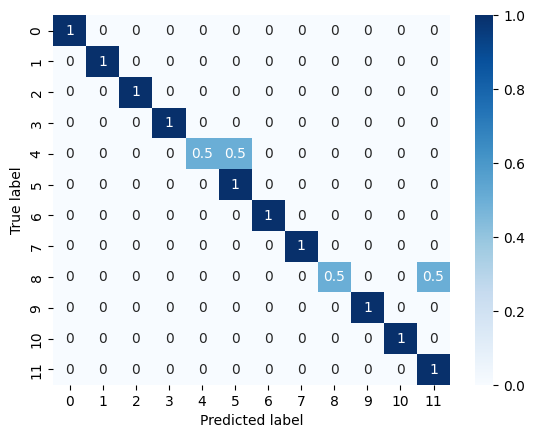

In [75]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='macro')  # 'macro' averages unweighted per class
recall = recall_score(y_val, y_pred, average='macro')
f1 = f1_score(y_val, y_pred, average='macro')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 score: {f1}")

# Create and visualize the confusion matri
confmat = confusion_matrix(y_val, y_pred, normalize="true")
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax, cmap="Blues")
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.show()


Best metric F1 score

### Hyperparameter optimisation

In [76]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Define a pipeline with scaler and SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

# Define parameter grid to search over
param_grid = {
    'svm__C': [0.1, 1, 10, 100],            # Regularization parameter
    'svm__kernel': ['linear', 'rbf', 'poly'],  # Different kernels
    'svm__gamma': ['scale', 'auto'],            # Kernel coefficient
    'svm__degree': [3, 4, 5]                     # Degree for 'poly' kernel
}

# Setup GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring='f1_macro',   # Optimize for macro F1 score
    cv=5,                # 5-fold cross-validation
    n_jobs=-1,           # Use all CPU cores
    verbose=2
)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation F1 score:", grid_search.best_score_)

# Use best estimator to predict on validation/test data
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'svm__C': 0.1, 'svm__degree': 3, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
Best cross-validation F1 score: 0.9188888888888889


### 6. Selection / Dimensionality Reduction

Question 6: Perform feature selection / dimension reduction using 2 methods of your choice that you think might perform better or yield insights.  Evaluate the performance using the same metric as point 5. Is there an improvement  in the performance and why do you think this is the case?   

### Recursive Feature Elimination (RFE)
Why best for EMG: Directly optimizes for your SVM classifier; EMG time-domain features have strong discriminative power that RFE captures well.

In [77]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC

# Select top k features using SVM-RFE 
svm_rfe = RFE(estimator=SVC(kernel='linear'), n_features_to_select=20, step=0.1)
X_train_selected = svm_rfe.fit_transform(X_train_z, y_train)
X_val_selected = svm_rfe.transform(X_val_z)

# Train SVM classifier
clf = SVC(kernel='rbf', C=1.0, gamma='scale')
clf.fit(X_train_selected, y_train)

# Predict on validation set
y_pred = clf.predict(X_val_selected)

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='macro')  # 'macro' averages unweighted per class
recall = recall_score(y_val, y_pred, average='macro')
f1 = f1_score(y_val, y_pred, average='macro')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 score: {f1}")


Accuracy: 0.9545454545454546
Precision: 0.9722222222222222
Recall: 0.9583333333333334
F1 score: 0.9555555555555556


In [78]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import Pipeline

# Create a pipeline: RFE + SVM
rfe_svm_pipeline = Pipeline([
    ('rfe', RFE(estimator=SVC(kernel='linear'), n_features_to_select=20, step=0.1)),
    ('svm', SVC(kernel='rbf', C=1.0, gamma='scale'))
])

# Cross-validation on TRAINING data only (5-fold CV)
cv_results = cross_validate(
    rfe_svm_pipeline, X_train_z, y_train,
    cv=5,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
    n_jobs=-1
)

# Print cross-validation results
print("=== CROSS-VALIDATION RESULTS (on training data) ===")
print(f"CV Accuracy: {cv_results['test_accuracy'].mean():.4f} ± {cv_results['test_accuracy'].std():.4f}")
print(f"CV Precision: {cv_results['test_precision_macro'].mean():.4f} ± {cv_results['test_precision_macro'].std():.4f}")
print(f"CV Recall: {cv_results['test_recall_macro'].mean():.4f} ± {cv_results['test_recall_macro'].std():.4f}")
print(f"CV F1 score: {cv_results['test_f1_macro'].mean():.4f} ± {cv_results['test_f1_macro'].std():.4f}")

# Fit pipeline on full training data
rfe_svm_pipeline.fit(X_train_z, y_train)

# Get selected features for validation set
X_val_selected = rfe_svm_pipeline.named_steps['rfe'].transform(X_val_z)

# Predict on validation set
y_pred = rfe_svm_pipeline.named_steps['svm'].predict(X_val_selected)

# Validation set metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='macro')
recall = recall_score(y_val, y_pred, average='macro')
f1 = f1_score(y_val, y_pred, average='macro')

print("\n=== VALIDATION SET RESULTS ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1:.4f}")

# Print selected feature indices (optional)
selected_features = rfe_svm_pipeline.named_steps['rfe'].support_
print(f"\nSelected {selected_features.sum()} features: {np.where(selected_features)[0]}")


=== CROSS-VALIDATION RESULTS (on training data) ===
CV Accuracy: 0.8739 ± 0.1094
CV Precision: 0.8583 ± 0.1150
CV Recall: 0.8750 ± 0.1054
CV F1 score: 0.8483 ± 0.1229

=== VALIDATION SET RESULTS ===
Accuracy: 0.9545
Precision: 0.9722
Recall: 0.9583
F1 score: 0.9556

Selected 20 features: [ 0  3 13 20 22 24 29 43 44 45 47 60 62 63 67 69 70 72 74 79]


In [80]:
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Create a pipeline: RFE → PCA → SVM
rfe_pca_svm_pipeline = Pipeline([
    ('rfe', RFE(estimator=SVC(kernel='linear'), n_features_to_select=30, step=0.1)),  # Select 30 features first
    ('pca', PCA(n_components=15)),  # Then reduce to 15 PCs
    ('svm', SVC(kernel='rbf', C=1.0, gamma='scale'))
])

# Cross-validation on TRAINING data only (5-fold CV)
cv_results = cross_validate(
    rfe_pca_svm_pipeline, X_train_z, y_train,
    cv=5,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
    n_jobs=-1
)

# Print cross-validation results
print("=== RFE + PCA + SVM CROSS-VALIDATION RESULTS ===")
print(f"CV Accuracy: {cv_results['test_accuracy'].mean():.4f} ± {cv_results['test_accuracy'].std():.4f}")
print(f"CV Precision: {cv_results['test_precision_macro'].mean():.4f} ± {cv_results['test_precision_macro'].std():.4f}")
print(f"CV Recall: {cv_results['test_recall_macro'].mean():.4f} ± {cv_results['test_recall_macro'].std():.4f}")
print(f"CV F1 score: {cv_results['test_f1_macro'].mean():.4f} ± {cv_results['test_f1_macro'].std():.4f}")

# Fit pipeline on full training data
rfe_pca_svm_pipeline.fit(X_train_z, y_train)

# Predict on validation set (pipeline handles all steps automatically)
y_pred = rfe_pca_svm_pipeline.predict(X_val_z)

# Validation set metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='macro')
recall = recall_score(y_val, y_pred, average='macro')
f1 = f1_score(y_val, y_pred, average='macro')

print("\n=== RFE + PCA + SVM VALIDATION RESULTS ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1:.4f}")

# Print RFE and PCA details (optional)
print(f"\nRFE selected {rfe_pca_svm_pipeline.named_steps['rfe'].n_features_} features:")
print(f"Selected feature indices: {np.where(rfe_pca_svm_pipeline.named_steps['rfe'].support_)[0]}")
print(f"PCA explained variance ratio: {rfe_pca_svm_pipeline.named_steps['pca'].explained_variance_ratio_.sum():.3f}")


=== RFE + PCA + SVM CROSS-VALIDATION RESULTS ===
CV Accuracy: 0.8850 ± 0.0703
CV Precision: 0.8611 ± 0.0609
CV Recall: 0.8833 ± 0.0612
CV F1 score: 0.8567 ± 0.0682

=== RFE + PCA + SVM VALIDATION RESULTS ===
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 score: 1.0000

RFE selected 30 features:
Selected feature indices: [ 0  2  3 10 12 13 20 21 22 23 24 25 29 43 44 45 46 47 48 50 60 62 63 65
 67 69 70 72 74 79]
PCA explained variance ratio: 0.987


In [79]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Create a pipeline: Mutual Info + SVM
mi_svm_pipeline = Pipeline([
    ('mi_selector', SelectKBest(score_func=mutual_info_classif, k=20)),  # Top 20 features by MI
    ('svm', SVC(kernel='rbf', C=1.0, gamma='scale'))
])

# Cross-validation on TRAINING data only (5-fold CV)
cv_results = cross_validate(
    mi_svm_pipeline, X_train_z, y_train,
    cv=5,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
    n_jobs=-1
)

# Print cross-validation results
print("=== MUTUAL INFO + SVM CROSS-VALIDATION RESULTS ===")
print(f"CV Accuracy: {cv_results['test_accuracy'].mean():.4f} ± {cv_results['test_accuracy'].std():.4f}")
print(f"CV Precision: {cv_results['test_precision_macro'].mean():.4f} ± {cv_results['test_precision_macro'].std():.4f}")
print(f"CV Recall: {cv_results['test_recall_macro'].mean():.4f} ± {cv_results['test_recall_macro'].std():.4f}")
print(f"CV F1 score: {cv_results['test_f1_macro'].mean():.4f} ± {cv_results['test_f1_macro'].std():.4f}")

# Fit pipeline on full training data
mi_svm_pipeline.fit(X_train_z, y_train)

# Get selected features for validation set
X_val_selected = mi_svm_pipeline.named_steps['mi_selector'].transform(X_val_z)

# Predict on validation set
y_pred = mi_svm_pipeline.named_steps['svm'].predict(X_val_selected)

# Validation set metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='macro')
recall = recall_score(y_val, y_pred, average='macro')
f1 = f1_score(y_val, y_pred, average='macro')

print("\n=== MUTUAL INFO + SVM VALIDATION RESULTS ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1:.4f}")

# Print selected feature scores and indices (optional)
mi_scores = mi_svm_pipeline.named_steps['mi_selector'].scores_
selected_features = mi_svm_pipeline.named_steps['mi_selector'].get_support()
top_features_idx = np.argsort(mi_scores)[-20:]  # Top 20 by MI score
print(f"\nTop 20 Mutual Information scores for features:")
for i, idx in enumerate(top_features_idx):
    print(f"Feature {idx}: MI score = {mi_scores[idx]:.4f}")


=== MUTUAL INFO + SVM CROSS-VALIDATION RESULTS ===
CV Accuracy: 0.7908 ± 0.1418
CV Precision: 0.7761 ± 0.1727
CV Recall: 0.8000 ± 0.1453
CV F1 score: 0.7606 ± 0.1637

=== MUTUAL INFO + SVM VALIDATION RESULTS ===
Accuracy: 0.9091
Precision: 0.9444
Recall: 0.9167
F1 score: 0.9111

Top 20 Mutual Information scores for features:
Feature 18: MI score = 0.8328
Feature 78: MI score = 0.8379
Feature 70: MI score = 0.8428
Feature 0: MI score = 0.8467
Feature 50: MI score = 0.8480
Feature 4: MI score = 0.8529
Feature 25: MI score = 0.8538
Feature 58: MI score = 0.8613
Feature 8: MI score = 0.8814
Feature 22: MI score = 0.8939
Feature 53: MI score = 0.8974
Feature 13: MI score = 0.9048
Feature 24: MI score = 0.9169
Feature 68: MI score = 0.9220
Feature 14: MI score = 0.9414
Feature 60: MI score = 0.9430
Feature 73: MI score = 0.9496
Feature 3: MI score = 0.9659
Feature 63: MI score = 0.9944
Feature 23: MI score = 1.0878


RFE+PCA method best I think?
RFE keeps discriminative features, PCA removes multicollinearity